# Лабораторная работа №3

## 1. Подготовка данных

### 1.0. Установка библиотек

In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

In [45]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [46]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [47]:
df.shape

(1338, 7)

### 1.1. Проверить наличие пропусков и выбросов

In [48]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [49]:
numeric_cols = df.select_dtypes(include=np.number).columns

In [50]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    print(f"{col}: выбросов {len(outliers)}")

age: выбросов 0
bmi: выбросов 9
children: выбросов 0
charges: выбросов 138


In [51]:
df.shape

(1191, 7)

In [52]:
1338 - 1191

147

### 1.2. Привести категориальные признаки к числовым

In [53]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_cols

Index(['sex', 'smoker', 'region'], dtype='object')

In [54]:
# One-Hot Encoding
df_encoded = pd.get_dummies(df, drop_first=True, dtype=int)

In [55]:
print("\nРазмерность до:", df.shape)
print("Размерность после:", df_encoded.shape)


Размерность до: (1191, 7)
Размерность после: (1191, 9)


In [56]:
df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


### 1.3. Вычислить парные корреляции признаков

In [57]:
corr_matrix = df_encoded.corr()

In [61]:
print("\nКорреляции признаков:")
display(corr_matrix.round(2))


Корреляции признаков:


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.00,0.12,0.04,0.45,-0.02,-0.06,-0.00,-0.02,0.02
bmi,0.12,1.00,0.01,-0.06,0.02,-0.26,-0.11,0.23,0.01
children,0.04,0.01,1.00,0.09,0.02,-0.00,0.01,-0.01,0.03
charges,0.45,-0.06,0.09,1.00,-0.02,0.60,0.04,-0.03,-0.08
sex_male,-0.02,0.02,0.02,-0.02,1.00,0.01,0.00,-0.00,-0.01
smoker_yes,-0.06,-0.26,-0.00,0.60,0.01,1.00,0.02,-0.00,-0.05
region_northwest,-0.00,-0.11,0.01,0.04,0.00,0.02,1.00,-0.34,-0.33
region_southeast,-0.02,0.23,-0.01,-0.03,-0.00,-0.00,-0.34,1.00,-0.33
region_southwest,0.02,0.01,0.03,-0.08,-0.01,-0.05,-0.33,-0.33,1.00


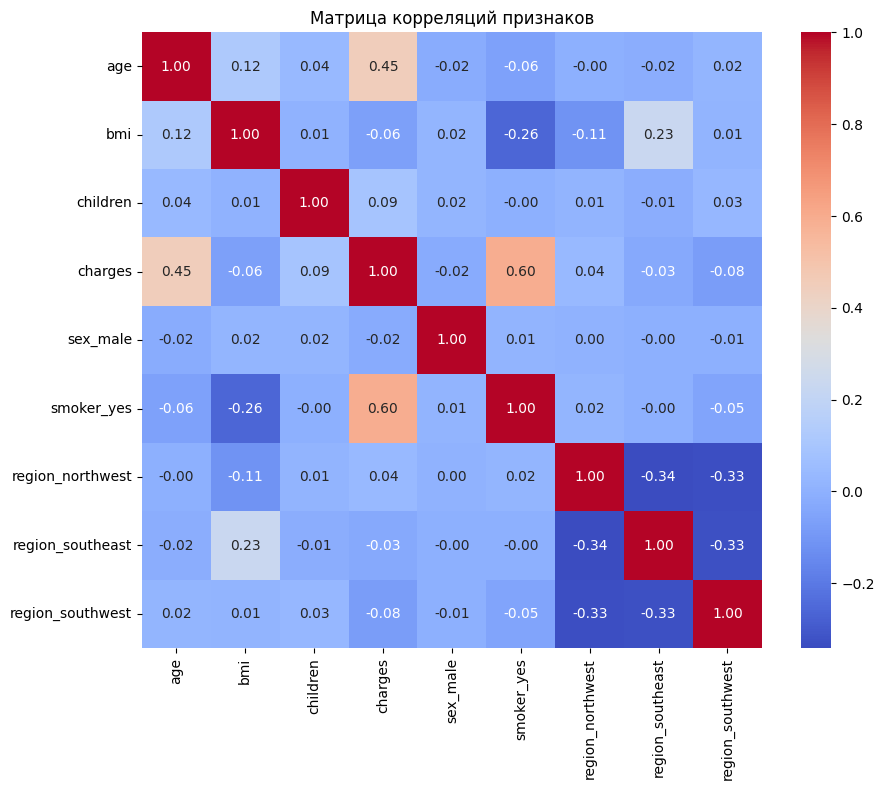

In [62]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Матрица корреляций признаков")
plt.show()

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:

2.1. Аналитически (реализовать самому)

In [71]:
y = df_encoded["charges"]
X = df_encoded.drop(columns="charges")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [72]:
X_train.shape, X_test.shape

((952, 8), (239, 8))

Формула для коэффициентов:
$
\hat{\beta} = (X^T X)^{-1} X^T y
$

In [77]:
X_np = X_train.to_numpy()         
y_np = y_train.to_numpy().reshape(-1, 1)
beta_analytic = np.linalg.inv(X_np.T @ X_np) @ X_np.T @ y_np
beta_analytic


array([[ 2.35593885e+02],
       [-4.08360481e+00],
       [ 4.22643742e+02],
       [-6.34130905e+02],
       [ 1.38537575e+04],
       [-6.49155467e+02],
       [-9.70792478e+02],
       [-1.56955486e+03]])

In [78]:
coef_names = [f"w{i}" for i in range(len(beta_analytic))]
df_coef = pd.DataFrame(beta_analytic.ravel(), index=coef_names, columns=["Значение"])
print(df_coef)

        Значение
w0    235.593885
w1     -4.083605
w2    422.643742
w3   -634.130905
w4  13853.757473
w5   -649.155467
w6   -970.792478
w7  -1569.554863


2.2. Численно, с помощью методов градиентного спуска (реализовать самому)

Функция потерь MSE:
$
J(w) = \frac{1}{m} \sum (y_i - \hat{y}_i)^2
$

Градиенты:
$
\frac{\partial J}{\partial w} = -\frac{2}{m} X^T (y - Xw)
$

In [116]:
w = np.zeros(8).reshape(-1, 1)
alpha = 4e-4
n_iters = 1000
tol = 1e-8
m = len(y)

losses = []


for i in range(n_iters):
    y_pred = X_np @ w        
    error = y_pred.reshape(-1, 1) - y_np 
    grad = (2 / m) * (X_np.T @ error)  
    w -= alpha * grad
    loss = float((error ** 2).mean())
    losses.append(loss)
    if losses[-1] < tol:
        print(f"Converged at iter {i}, loss={losses[-1]:.3e}")
        break

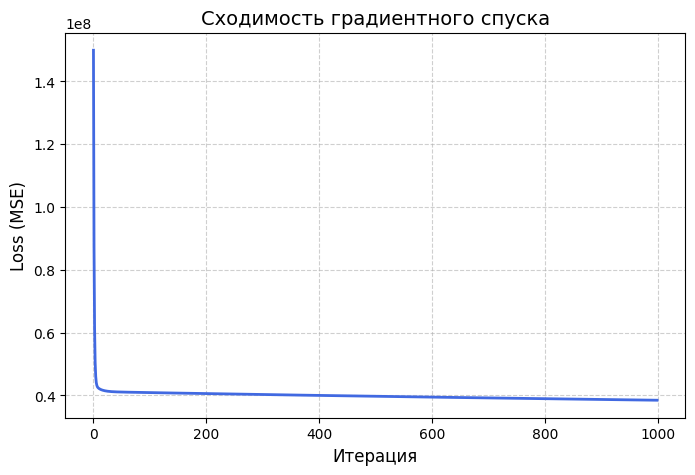

In [117]:
plt.figure(figsize=(8,5))
plt.plot(range(len(losses)), losses, color='royalblue', linewidth=2)
plt.title("Сходимость градиентного спуска", fontsize=14)
plt.xlabel("Итерация", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:

### 3.1. Аналитически

In [127]:
def ridge_closed_form(X, y, lam=0.0, fit_intercept=True):
    """
    X: (m, n) numpy array, без константы если fit_intercept=True
    y: (m, 1) или (m,) numpy array
    lam: non-negative float (lambda)
    fit_intercept: если True — добавляем столбец единиц и НЕ регуляризуем интерсепт
    Returns: beta (n_with_intercept, 1)
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1, 1)
    m, n = X.shape

    if fit_intercept:
        Xb = np.hstack([np.ones((m, 1)), X])
    else:
        Xb = X

    _, p = Xb.shape
    if fit_intercept:
        reg = np.eye(p)
        reg[0, 0] = 0.0
    else:
        reg = np.eye(p)

    A = Xb.T @ Xb + lam * reg
    B = Xb.T @ y

    beta = np.linalg.solve(A, B)
    return beta 


def select_lambda_via_cv(X, y, lam_grid=None, k=5, fit_intercept=True, random_state=0):
    """
    lam_grid: iterable of lambda values to try
    Возвращает (best_lambda, best_beta, cv_results (dict))
    """
    if lam_grid is None:
        lam_grid = np.logspace(-6, 4, 40)
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

    mean_mses = []
    for lam in lam_grid:
        mses = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            beta = ridge_closed_form(X_train, y_train, lam=lam, fit_intercept=fit_intercept)
            # предсказания
            if fit_intercept:
                Xval_b = np.hstack([np.ones((len(X_val), 1)), X_val])
            else:
                Xval_b = X_val
            y_pred = (Xval_b @ beta).ravel()
            mses.append(mean_squared_error(y_val.ravel(), y_pred))
        mean_mses.append(np.mean(mses))

    mean_mses = np.array(mean_mses)
    best_idx = np.argmin(mean_mses)
    best_lambda = lam_grid[best_idx]

    best_beta = ridge_closed_form(X, y, lam=best_lambda, fit_intercept=fit_intercept)
    cv_results = {"lam_grid": lam_grid, "mean_mses": mean_mses}
    return best_lambda, best_beta, cv_results


In [150]:
lam_grid = np.logspace(-6, 6, 50) 
best_lambda, best_beta, cv_res = select_lambda_via_cv(X_np, y_np, lam_grid=lam_grid, k=5)

print("Best lambda:", best_lambda)
print("Coefficients (beta):")
for i, val in enumerate(best_beta.ravel()):
    if i == 0:
        name = "intercept"
    else:
        name = f"w{i}"
    print(f"{name:12s}: {val:12.4f}")


Best lambda: 1e-06
Coefficients (beta):
intercept   :   -3067.5531
w1          :     247.3764
w2          :      69.5620
w3          :     473.0576
w4          :    -480.5158
w5          :   14341.6012
w6          :    -368.1588
w7          :    -920.0032
w8          :   -1348.0794


### 3.2. Численно

In [131]:
def ridge_gradient_descent(X, y, lam=0.0, fit_intercept=True, alpha=1e-4, n_iters=10000, tol=1e-8):
    """
    X: (m, n) numpy array
    y: (m,) или (m,1)
    lam: L2-регуляризация
    fit_intercept: добавлять ли столбец единиц
    alpha: шаг градиентного спуска
    n_iters: макс. число итераций
    tol: остановка по норме градиента
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1, 1)
    m, n = X.shape

    if fit_intercept:
        Xb = np.hstack([np.ones((m,1)), X])
    else:
        Xb = X

    _, p = Xb.shape
    w = np.zeros((p,1))
    reg = np.eye(p)
    if fit_intercept:
        reg[0,0] = 0.0

    losses = []

    for i in range(n_iters):
        y_pred = Xb @ w
        error = y_pred - y
        grad = (2/m) * (Xb.T @ error) + 2 * lam * reg @ w
        w -= alpha * grad

        loss = float((error**2).mean() + lam * (w[1:]**2).sum())
        losses.append(loss)

        if np.linalg.norm(grad) < tol:
            break

    return w, losses

def select_lambda_via_cv_numeric(X, y, lam_grid=None, k=5, fit_intercept=True, alpha=1e-3, n_iters=100):
    """
    Подбор лучшего λ для Ridge (L2) через численный градиентный спуск
    """
    if lam_grid is None:
        lam_grid = np.logspace(-6, 6, 20)

    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    mean_mses = []

    for lam in lam_grid:
        mses = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            beta, _ = ridge_gradient_descent(X_train, y_train, lam=lam, fit_intercept=fit_intercept,
                                             alpha=alpha, n_iters=n_iters)
            if fit_intercept:
                X_val_b = np.hstack([np.ones((len(X_val),1)), X_val])
            else:
                X_val_b = X_val
            y_pred = (X_val_b @ beta).ravel()
            mses.append(mean_squared_error(y_val.ravel(), y_pred))

        mean_mses.append(np.mean(mses))

    mean_mses = np.array(mean_mses)
    best_idx = np.argmin(mean_mses)
    best_lambda = lam_grid[best_idx]

    best_beta, _ = ridge_gradient_descent(X, y, lam=best_lambda, fit_intercept=fit_intercept,
                                         alpha=alpha, n_iters=n_iters)

    cv_results = {"lam_grid": lam_grid, "mean_mses": mean_mses}
    return best_lambda, best_beta, cv_results


In [140]:
lam_grid = np.logspace(-6, 6, 20)
best_lambda, best_beta, cv_res = select_lambda_via_cv_numeric(X_np, y_np, lam_grid=lam_grid, k=5, alpha=1e-5, n_iters=100)

print("Best lambda (L2):", best_lambda)
print("Coefficients (beta):")
for i, val in enumerate(best_beta.ravel()):
    name = "intercept" if i==0 else f"w{i}"
    print(f"{name:12s}: {val:12.4f}")

Best lambda (L2): 1e-06
Coefficients (beta):
intercept   :       3.6409
w1          :     179.9928
w2          :      95.7937
w3          :       5.3733
w4          :       1.4976
w5          :       3.2277
w6          :       1.0731
w7          :       0.7285
w8          :       0.3254


## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:

### 4.1. Константную - прогноз средним значением

In [142]:
y_pred_const = np.full_like(y_test, y_train.mean())
mse_const = mean_squared_error(y_test, y_pred_const)
mse_const

46216480.785036765

### 4.2. Из пункта 2

In [145]:
preds = X_test @ beta_analytic
mse_lr = mean_squared_error(y_test, preds)
mse_lr

17919228.55047872

### 4.3. Из пункта 3

In [ ]:
preds = X_test @ best_beta.ravel()[1:] +  best_beta.ravel()[0]
mse_lr_ridge = mean_squared_error(y_test, preds)
mse_lr_ridge

17765964.35307197